# Plotting timeseries of Arctic windspeeds - bootstrapped means

* **Description**: Plots historical and future timeseries by month and region
* **Input data**: Processed rufmod and cesm2-le regional total netcdf files
* **Output data**: Timeseries plots in png format
* **Creator**: Alice DuVivier
* **Date**: December 2021

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t, ttest_ind


## Read in the processed data

This reads in pre-processed regional average atmospheric circulation for the Arctic: 70-90N over ocean.


In [2]:
# list the variables to load
var_in = 'U10'

In [3]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_7/fig_3_sfc_wind_state/'

# set file names
fin_le = 'CESM2-LE_all_transient_regional_avg_'+var_in
fin_rufmod = 'rufmod_all_transient_regional_avg_'+var_in

In [4]:
ds_le = xr.open_dataset(data_dir+fin_le+'.nc',decode_times=True)
ds_rufmod = xr.open_dataset(data_dir+fin_rufmod+'.nc',decode_times=True)

In [5]:
# double check that year/month is not shifted incorrectly
ds_le.coords['time.month']
ds_rufmod.coords['time.month']

<xarray.DataArray 'month' (time: 1032)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [6]:
print(ds_le.units)
print(ds_le.longname)

total_le = ds_le['regional_totals']
total_rufmod = ds_rufmod['regional_totals']

m/s
10m wind speed 70-90N


# keep just 2015 onward
total_le = total_le.isel(time=slice(1980,3011))
total_rufmod = total_rufmod.isel(time=slice(1980,3011))

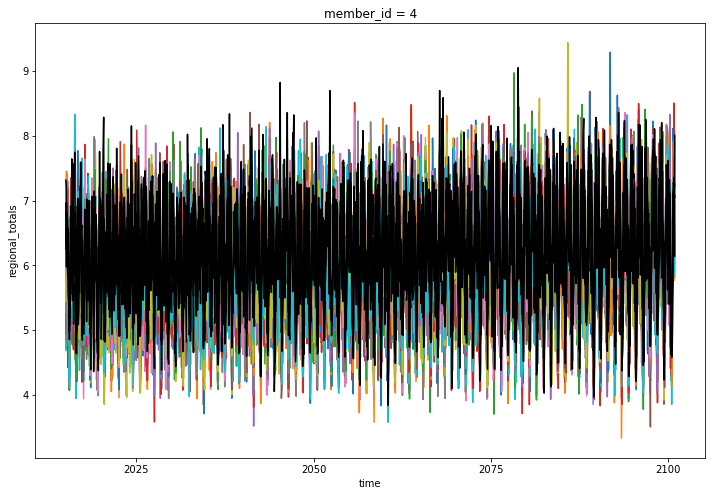

In [7]:
#Plot rough version just to check
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

#CESM2-LE
# Loop through and plot each member_id all months in 251 years
for member_id in total_le.member_id.values:
    total_le.sel(member_id=member_id).plot(ax=ax)
#rufmod
# Loop through and plot each member_id all months overlay in black
for member_id in total_rufmod.member_id.values:
    total_rufmod.sel(member_id=member_id).plot(ax=ax,color='black')

## Set a few plotting things

In [8]:
# set x arrays against which to plot
xarr_le = total_le.coords['time.year'][(total_le.coords['time.month']==1)]
xarr_rufmod = total_le.coords['time.year'][(total_le.coords['time.month']==1)]

In [9]:
xarr_le

<xarray.DataArray 'year' (time: 86)>
array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-01-16 12:00:00

In [10]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [11]:
#set some labeling info for plots
out_tag = 'U10'
label = '10m wind speed'
units = label+' ($m\ s^{-1}$)'

## Calculate and plot monthly averages

In [12]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
len(month_names)

# Use .groupby('time.month') to organize the data into months
# then use .groups to extract the indices for each month
month_idxs_le=total_le.groupby('time.month').groups
month_idxs_rufmod=total_rufmod.groupby('time.month').groups

In [13]:
jan_indexes = month_idxs_le[1]  # start indexing with 1, not 0
len(jan_indexes)
total_le.time[month_idxs_le[1]]

<xarray.DataArray 'time' (time: 86)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2020, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2021, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2022, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2023, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2024, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2025, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2026, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2027, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2028, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2029, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2030, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2031, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2032, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2033, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2034, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2035, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2036, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2037, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2038, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2039, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2040, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2041, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2042, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2043, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2044, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2045, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2046, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2047, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2048, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2049, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2050, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2051, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2052, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2053, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2054, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2055, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2056, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2057, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2058, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2059, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2060, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2061, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2062, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2063, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2064, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2065, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2066, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cfti

In [14]:
# test that we're looking at correct indices and the le is transposed properly
for mm in months:
    mstr = month_names[mm-1]
    print('Testing indices for month '+mstr)
    data_temp = total_le.isel(time=month_idxs_le[mm]).transpose()
    print(data_temp.shape)
    data_temp = total_rufmod.isel(time=month_idxs_rufmod[mm])
    print(data_temp.shape)

Testing indices for month Jan
(86, 50)
(5, 86)
Testing indices for month Feb
(86, 50)
(5, 86)
Testing indices for month Mar
(86, 50)
(5, 86)
Testing indices for month Apr
(86, 50)
(5, 86)
Testing indices for month May
(86, 50)
(5, 86)
Testing indices for month Jun
(86, 50)
(5, 86)
Testing indices for month Jul
(86, 50)
(5, 86)
Testing indices for month Aug
(86, 50)
(5, 86)
Testing indices for month Sep
(86, 50)
(5, 86)
Testing indices for month Oct
(86, 50)
(5, 86)
Testing indices for month Nov
(86, 50)
(5, 86)
Testing indices for month Dec
(86, 50)
(5, 86)


## Calculate seasonal averages

In [15]:
season_names = ['OND', 'JFM', 'AMJ', 'JAS']
season_full = ['a) Autumn', 'b) Winter', 'c) Spring', 'd) Summer']

# calculate seasonal indexes  - DIDN'T END UP DOING IT THIS WAY, DID IT MANUALLY FOR GROUPINGS ABOVE
#season_names = ['DJF', 'MAM', 'JJA', 'SON']
#season_idxs_le = sidragtop_masked_le.groupby('time.season').groups
#season_idxs_rufmod = sidragtop_masked_rufmod.groupby('time.season').groups

In [16]:
# Loop through seasons - CESM2-LE

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(season_names),len(xarr_le),len(total_le.member_id)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = total_le.isel(time=total_le.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = total_le.isel(time=total_le.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = total_le.isel(time=total_le.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = total_le.isel(time=total_le.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        seas_array_le[s_count,y_count,:] = temp2.mean(dim='time')


OND
JFM
AMJ
JAS


In [17]:
# Loop through seasons - rufmod

# make numpy array to fill and specify dimensions we want
seas_array_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(total_rufmod.member_id)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = total_rufmod.isel(time=total_rufmod.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = total_rufmod.isel(time=total_rufmod.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = total_rufmod.isel(time=total_rufmod.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = total_rufmod.isel(time=total_rufmod.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_rufmod:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        seas_array_rufmod[s_count,y_count,:] = temp2.mean(dim='time')

OND
JFM
AMJ
JAS


In [18]:
print(seas_array_le.shape)
print(seas_array_rufmod.shape)

(4, 86, 50)
(4, 86, 5)


In [19]:
# convert the numpy array to a xarray for easier plotting
seas_le = xr.DataArray(seas_array_le,dims=('season','time','member_id'))
seas_rufmod = xr.DataArray(seas_array_rufmod,dims=('season','time','member_id'))

In [20]:
seas_le.isel(season=0)

<xarray.DataArray (time: 86, member_id: 50)>
array([[6.20225906, 5.67839432, 6.11901712, ..., 5.98301935, 5.82188082,
        5.65482092],
       [6.00895071, 5.54869223, 5.78750944, ..., 5.93972015, 5.34507895,
        6.27030802],
       [5.96176863, 5.77737188, 6.082407  , ..., 5.55621386, 5.49348497,
        5.62936449],
       ...,
       [6.49007177, 6.48782873, 6.39084244, ..., 7.13049316, 6.86909533,
        6.91550303],
       [6.99049377, 7.57302237, 6.85238647, ..., 7.0995965 , 7.10870504,
        7.43463945],
       [7.24934912, 7.54377604, 7.25783396, ..., 6.57607031, 6.41648531,
        6.8779664 ]])
Dimensions without coordinates: time, member_id

## Calculate ensemble means and bootstrapped means

Bootstrap the CESM2-LE (N=50) to find ensemble means using the same number of members as SMOOTH (N=5)

In [21]:
seas_le = seas_le.transpose()
seas_rufmod = seas_rufmod.transpose()
print(seas_le.shape)
print(seas_rufmod.shape)

(50, 86, 4)
(5, 86, 4)


In [22]:
print(seas_le.member_id)

<xarray.DataArray 'member_id' (member_id: 50)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
Dimensions without coordinates: member_id


In [23]:
# calculate ensemble mean for SMOOTH and CESM2-LE over all members
seas_ens_mean_le = seas_le.mean(dim='member_id')
seas_ens_mean_rufmod = seas_rufmod.mean(dim='member_id')

In [24]:
# calculate statistical significance
sigval = 0.05

# calculate statistical significance
tval,pval = ttest_ind(seas_le,seas_rufmod,axis=0,equal_var=False)
seas_ens_mean_le_sig = seas_ens_mean_le.where(pval <= sigval)
seas_ens_mean_rufmod_sig = seas_ens_mean_rufmod.where(pval <= sigval)

In [25]:
print(seas_ens_mean_le.shape)
print(seas_ens_mean_rufmod.shape)

(86, 4)
(86, 4)


In [26]:
# bootstrap the CESM2-LE 1000 times
n_bs=1000
seas_bs_array_le = np.zeros([len(season_names),len(xarr_le),n_bs])

for ii in range(n_bs):
    # choose random ensemble member numbers
    mem1=np.random.choice(range(0,49))
    mem2=np.random.choice(range(0,49))
    mem3=np.random.choice(range(0,49))
    mem4=np.random.choice(range(0,49))
    mem5=np.random.choice(range(0,49)) 
    # now average those random ensembles
    temp = np.stack((seas_le.isel(member_id=mem1),seas_le.isel(member_id=mem2),seas_le.isel(member_id=mem3),
                     seas_le.isel(member_id=mem4),seas_le.isel(member_id=mem5)),axis=-1)
    temp2 = np.mean(temp,axis=2)
    seas_bs_array_le[:,:,ii]=temp2.transpose()

In [27]:
seas_bs_array_le.shape

(4, 86, 1000)

In [28]:
# convert the numpy array to a xarray for easier plotting
seas_bs_le = xr.DataArray(seas_bs_array_le,dims=('season','time','bootstrap_num'))

## Plot the figures

## Add linear regressions

In [29]:
# note that the CESM2-LE time bounds for regressions are:
# 2020-2100: 5-85
print(xarr_le[5])
print(xarr_le[85])
#seas_ens_mean_le

<xarray.DataArray 'year' ()>
array(2020)
Coordinates:
    time     object 2020-01-16 12:00:00
<xarray.DataArray 'year' ()>
array(2100)
Coordinates:
    time     object 2100-01-16 12:00:00


In [30]:
# note that the rufmod time bounds for regressions are:
# 2020-2100: 5-85
print(xarr_rufmod[5])
print(xarr_rufmod[85])
#seas_ens_mean_rufmod

<xarray.DataArray 'year' ()>
array(2020)
Coordinates:
    time     object 2020-01-16 12:00:00
<xarray.DataArray 'year' ()>
array(2100)
Coordinates:
    time     object 2100-01-16 12:00:00


In [31]:
seas_ens_mean_le

<xarray.DataArray (time: 86, season: 4)>
array([[5.89458192, 5.90606691, 5.4624955 , 5.42517302],
       [5.85399432, 5.75333275, 5.56601502, 5.52508558],
       [5.81773363, 5.87909595, 5.49928067, 5.51074879],
       [5.86433845, 5.93125432, 5.47238825, 5.53390501],
       [5.83170072, 5.88361939, 5.52469646, 5.4428454 ],
       [5.89585256, 5.89241638, 5.43127408, 5.50839969],
       [5.8512866 , 5.83153409, 5.58288993, 5.5322445 ],
       [5.8549205 , 5.80687917, 5.38861221, 5.51082821],
       [5.86631642, 5.89689907, 5.44041405, 5.47653155],
       [5.89948405, 5.81965037, 5.56256857, 5.44796276],
       [5.83966799, 5.90486657, 5.5826532 , 5.46356151],
       [5.88759757, 5.82762176, 5.53423778, 5.52732738],
       [5.90148905, 5.94387938, 5.48912711, 5.55544459],
       [5.92136811, 5.78756763, 5.44549471, 5.46338201],
       [6.01679063, 5.90708158, 5.47222108, 5.58665144],
       [5.95134329, 5.86104638, 5.51854814, 5.5942162 ],
       [5.9976981 , 5.88864573, 5.4472233 , 5.51424238],
       [5.90095402, 5.90342352, 5.53756427, 5.61330793],
       [5.97438489, 5.92660111, 5.54500439, 5.55257205],
       [5.96008767, 5.86175762, 5.43241152, 5.4906199 ],
...
       [6.60101341, 6.14555884, 5.56012004, 5.70907505],
       [6.69560657, 6.16715067, 5.49155436, 5.75303822],
       [6.75048872, 6.05327884, 5.5126096 , 5.74205212],
       [6.67184168, 6.13474147, 5.50424614, 5.73346294],
       [6.72667153, 6.14751623, 5.4861797 , 5.70706752],
       [6.72826284, 6.15078125, 5.53636407, 5.7418286 ],
       [6.80428633, 6.15928782, 5.54585636, 5.72909496],
       [6.78373376, 6.21407067, 5.46265669, 5.72064337],
       [6.7670947 , 6.15717477, 5.55979926, 5.66882642],
       [6.8759428 , 6.28485041, 5.44931129, 5.66448906],
       [6.87549006, 6.30026136, 5.5065574 , 5.76174844],
       [6.85443594, 6.30601733, 5.53950196, 5.70939477],
       [6.89411325, 6.4178878 , 5.52379175, 5.6821089 ],
       [6.8708388 , 6.35599856, 5.49144709, 5.75128331],
       [6.9315915 , 6.32702765, 5.52145165, 5.72414595],
       [6.86631372, 6.39437114, 5.50931377, 5.69973873],
       [6.90642797, 6.41996437, 5.57650192, 5.70478332],
       [6.87388451, 6.31822038, 5.53815053, 5.68810847],
       [7.02169228, 6.49117876, 5.59791628, 5.74547462],
       [7.01558527, 6.45700621, 5.6047169 , 5.69820662]])
Dimensions without coordinates: time, season

In [32]:
# test this simply for first season
seas = 0

x = xarr_le[5:85]
y = seas_ens_mean_le[5:85,seas]
regobj = linregress(x,y)
#regobj = scipy.stats.linregress(x,y)
print(regobj)
print('rate = '+str(10*regobj.slope)+' m/s/decade')
print('r2='+str((regobj.rvalue*regobj.rvalue)))

LinregressResult(slope=0.014327583352333495, intercept=-23.139462338416724, rvalue=0.9920964264430558, pvalue=4.426704450856503e-72, stderr=0.00020518172893868426)
rate = 0.14327583352333495 m/s/decade
r2=0.9842553193610817


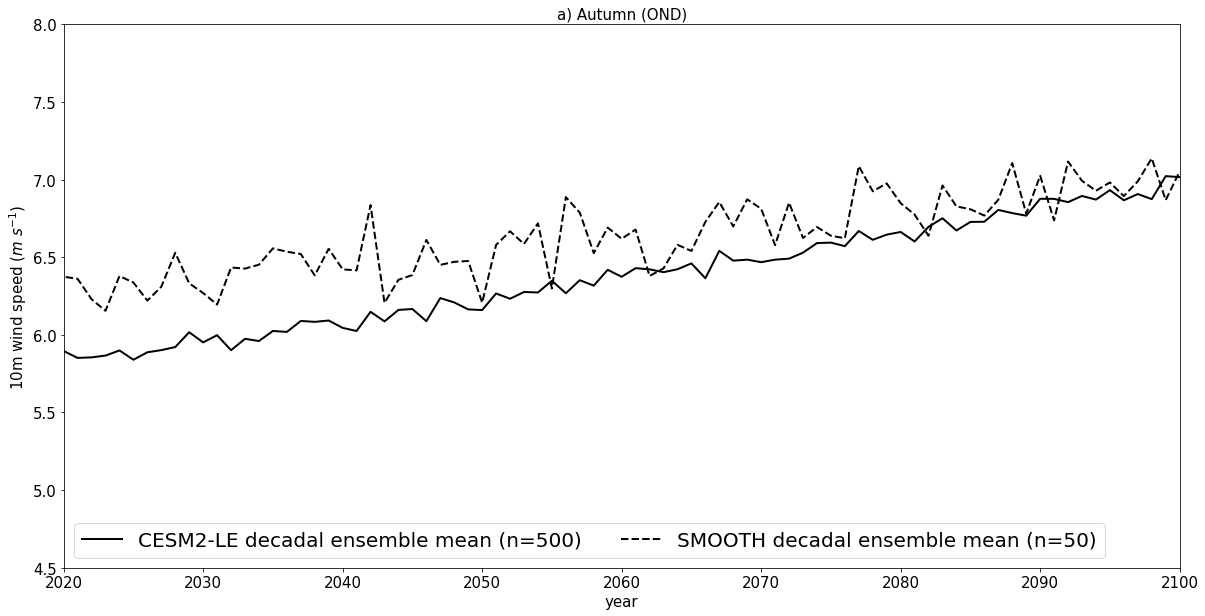

In [35]:
# like above, but add linear regression over the whole period
ind_le_st = 5
ind_le_ed = 85
ind_rufmod_st = ind_le_st
ind_rufmod_ed = ind_le_ed

# create figure
fig = plt.figure(figsize=(20,10))
# now loop through months to create subpanels
fout = 'fig_5_legend'

for ss in season_names[0:1]:
#for ss in season_names:
    #print(ss)
    if ss == 'OND':
        count = 0
    else: 
        count = count+1

    # CESM2-LE: subset the data
    data_temp_le = seas_bs_le.isel(season=count)
    mean_le = seas_ens_mean_le.isel(season=count)
    mean_le_sig = seas_ens_mean_le_sig.isel(season=count)
    # rufmod: subset the data
    mean_rufmod = seas_ens_mean_rufmod.isel(season=count)
    mean_rufmod_sig = seas_ens_mean_rufmod_sig.isel(season=count)
    
    # calculate LE linear regression for whole time period
    x_le = xarr_le[ind_le_st:ind_le_ed]
    y_le = mean_le[ind_le_st:ind_le_ed]
    reg_le = linregress(x_le,y_le)
    rate_le = 10*reg_le.slope
    r2_le = reg_le.rvalue*reg_le.rvalue
    y_reg_le = (reg_le.slope*x_le)+reg_le.intercept
    tx_le = 'CESM2-LE rate '+str(round(rate_le,3))+' (m/s)/decade; $r^{2}$='+str(round(r2_le,2))
    
    # calculate rufmod linear regression for whole time period
    x_rufmod = xarr_rufmod[ind_rufmod_st:ind_rufmod_ed]
    y_rufmod = mean_rufmod[ind_rufmod_st:ind_rufmod_ed]
    reg_rufmod = linregress(x_rufmod,y_rufmod)
    rate_rufmod = 10*reg_rufmod.slope
    r2_rufmod = reg_rufmod.rvalue*reg_rufmod.rvalue
    y_reg_rufmod = (reg_rufmod.slope*x_rufmod)+reg_rufmod.intercept
    tx_rufmod = 'SMOOTH rate '+str(round(rate_rufmod,3))+' (m/s)/decade; $r^{2}$='+str(round(r2_rufmod,2))

    # Make subplot - note it's nrow x ncol x index (starting upper left)
    ax = fig.add_subplot(1,1,count+1)
    # plot ensemble means
    ax.plot(xarr_le,mean_le,label="CESM2-LE decadal ensemble mean (n=500)",color='black',linestyle='solid',linewidth=2)
    ax.plot(xarr_rufmod,mean_rufmod,label="SMOOTH decadal ensemble mean (n=50)",color='black',linestyle='dashed',linewidth=2)
    
    plt.title(season_full[count]+' ('+ss+')',fontsize=15)
    plt.xlabel('year',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim([2020,2100])
    plt.ylabel(units,fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([4.5,8.0])
    plt.legend(loc='lower left', fontsize=20, ncol=2);
    
# Finalize figure and save
# save figure
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
